In [16]:
!pip install lightning --quiet

In [ ]:
# strongly inspired by https://lightning.ai/docs/pytorch/stable/notebooks/lightning_examples/mnist-hello-world.html
import os

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import CIFAR10

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 128
EPOCHS = 2
LR = 0.0001

In [11]:
class CNNModel(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (3, 32, 32)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LR)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            dataset = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.train_db, self.val_db = random_split(dataset, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.test_db = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_db, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.val_db, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.test_db, batch_size=BATCH_SIZE)

In [13]:
model = CNNModel()
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=EPOCHS,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO: 
  | Name           | Type               | Params
------------------------------------------------------
0 | model          | Sequential         | 1.1 M 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.283     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type               | Params
------------------------------------------------------
0 | model          | Sequential         | 1.1 M 
1 | train_accuracy | MulticlassAccuracy | 0     
2 | val_accuracy   | MulticlassAccuracy | 0     
3 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.283     Total estimate

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [14]:
trainer.test()

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified


INFO: Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=1-step=704.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=1-step=704.ckpt
INFO: Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=1-step=704.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=1-step=704.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5041999816894531     │
│         test_loss         │     1.399402379989624     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.399402379989624, 'test_acc': 0.5041999816894531}]

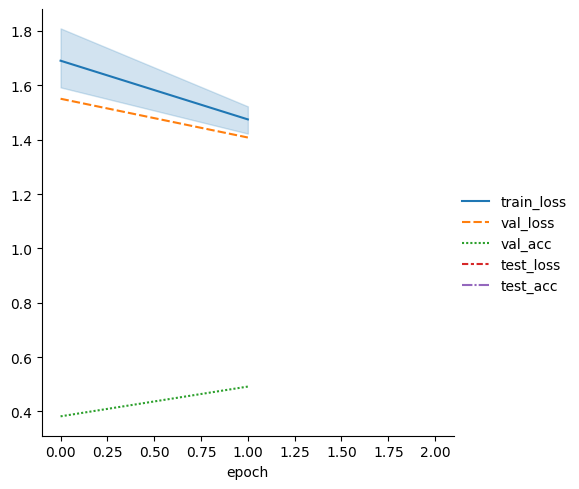

In [17]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
sn.relplot(data=metrics, kind="line")